# Quick introduction
The goal of this project is to reduce the patience doctor ratio for Zambian clinics and hospitals. One of the ways in which we can archive this is explore the common issues that patients see a doctor for and attempt to find alternative ways in which those issue can be found. OOne of the the issues topping the list was that of skin infections. In this notebook, will train a model that uses deep lesrning to distingusih betwwen various skin deaseses.

## Undestanding skin infections
There are mulptiple types of skin deases that have varrying implications from death threatening to naive ones that may not require immideate intervention. Severity here ranges from trivial mosquito bites, irritations due to allegies, blister all the way to more complex ones likes STD's and Cellulitis which may require medical emergence upon suspision. 

## Datasets
For the training, we will be using the Skin Disease Dataset from kagle availabe [here](https://www.kaggle.com/data/58249) which consists of over 23000 images of different kinds of skin infections.

We begin by declaring all the imports that will reuired for the traing as indicated below.

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from torchvision import datasets, transforms, models
from PIL import Image
import numpy as np
from collections import OrderedDict
import time
from datetime import datetime

In [13]:
!wget https://www.dropbox.com/s/orzmva086c99l64/2013-05-21%2009.35.48-1.jpg?dl=0 -O data.tar.gz

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/root/.wget-hsts'. HSTS will be disabled.
--2020-02-04 21:40:16--  https://doc-0k-4s-docs.googleusercontent.com/docs/securesc/b0jf9sa6237ssj456kipbr269f06suor/78corbf6lqak379n14fnvedke4hgus7r/1580839200000/12638554975200570473/12638554975200570473/1oFPcZjPIHy1889fDh0q3QAsWIqeKRdC7?e=download&authuser=0&nonce=t297sq7uave4o&user=12638554975200570473&hash=rmo80qeoue05uathb5qtf7qj30hi1f30
Resolving doc-0k-4s-docs.googleusercontent.com (doc-0k-4s-docs.googleusercontent.com)... 172.217.170.1, 2c0f:fb50:4002:804::2001
Connecting to doc-0k-4s-docs.googleusercontent.com (doc-0k-4s-docs.googleusercontent.com)|172.217.170.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://docs.google.com/u/0/nonceSigner?nonce=pvpm4d92nqidg&continue=https://doc-0k-4s-docs.googleusercontent.com/docs/securesc/b0jf9sa6237ssj456kipbr269f06suor/78corbf6lqak379n

In [15]:
!ls

Data	     data.tar.gz    model_best.pth.tar	skin_disease_sagemaker.ipynb
checkpoints  data_split.py  skin_disease.ipynb	wget-log


## Loading the data
We load the data from the directory provided and peform image transformations like rotations, horizontal flips etc.. We then load a pre trained model from torchvision and difine a classifer for it.

In [6]:
data_dir = 'Data'
train_dir = data_dir+'/train'
test_dir = data_dir+'/val'

In [7]:
# peform data transafomrations for the training set.
train_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(244),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

# load the datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# define the dataloader
trainloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)
testloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=32)

In [8]:
# download a pre trained model
model_name = 'resnet152'
model = models.resnet152(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
## Freeze the parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [9]:
# modify the classifier to match the dataset
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(2048, 1000)),
    ('Dropout', nn.Dropout(0.7)),
    ('ReLU', nn.ReLU()),
    ('Dropout', nn.Dropout(0.25)),
    ('fc2', nn.Linear(1000, 47)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.fc = classifier

In [10]:
# set the learning ratet
learning_rate = 0.001

In [11]:
# set the optimizer to adam
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

In [12]:
# set the loss function
criterion = nn.NLLLoss()

In [13]:
# set device agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
device.type

'cpu'

In [15]:
# declare the variables for ploting
running_loses, test_loses = [], []

In [ ]:
model.to(device)
epochs = 70
steps = 0
print_every = 5
starting_time = time.time()

# print a statement to show the start of the training along with the number of epochs
print("########################################################\n")
print("Stating the training at: \n",
      "Time: {}\nEpochs: {}\nDevice: {}\nLearning rate: {}\nArchitecture: {}\n".
      format(datetime.now().strftime('%H:%M:%S'), epochs, device.type, learning_rate, model_name),
             "########################################################")

# start training the model
for e in range(epochs):
    running_loss = 0
    steps+=1
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the gradients
        optimizer.zero_grad()
        
        logps = model(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    if steps%print_every == 0:
        test_loss = 0
        accuracy = 0
            
        with torch.no_grad():
            model.eval()
                
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                    
                logps = model(inputs)
                loss = criterion(logps, labels)
                
                test_loss += loss.item()
                    
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
            # append the loses for graphing
            running_loses.append(running_loss/len(trainloader))
            test_loses.append(test_loss/len(testloader))
                    
            print("Epoch: {}/{}".format(e+1,epochs),
                  "Running loss: {:.3f}..".format(running_loss/len(trainloader)),
                  "Test loss: {:.3f}..".format(test_loss/len(testloader)),
                  "Accuracy: {:.3f}..".format(accuracy.item()/len(testloader)*100))
                    
            model.train()
stoping_time = time.time()
duration = stoping_time-starting_time

########################################################

Stating the training at: 
 Time: 19:48:29
Epochs: 70
Device: cpu
Learning rate: 0.001
Architecture: resnet152
 ########################################################


In [36]:
# run this cell if you manully stoped the traning
duration = time.time() - starting_time

In [37]:
duration/3600

8.05049997859531

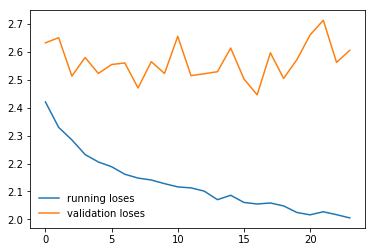

In [38]:
# a plot of the progress with matplotlib
%matplotlib inline
%config InlineBackend.figure_fromat = 'retina'

plt.plot(running_loses, label='running loses')
plt.plot(test_loses, label='validation loses')
plt.legend(frameon=False)

## Saving and loading trained models
After trainig the model, it is important to save the current state parameters and all other parameters that may help compare the architectures and the hyperparameters.

In [25]:
checkpoint_dir = 'checkpoints/'
!mkdir checkpoints
!ls

mkdir: cannot create directory ‘checkpoints’: File exists
checkpoints	    test	       test.zip?dl=0  train_emb.zip?dl=0
skin_disease.ipynb  test_emb.zip?dl=0  train	      train.zip?dl=0


In [39]:
# crete custom dictionary to save additional params
checkpoint = {'epoch': e,
              'learning_rate': learning_rate,
              'arch': 'cpu',
              'optimizer_state_dict': optimizer.state_dict(),
             'model_state_dict': model.state_dict(),
              'loss': loss,
             'duration': duration}

# save the model
torch.save(checkpoint, checkpoint_dir+model_name+'.pth')

In [ ]:
# load a saved model from disk to coninue traning
checkpoint = torch.load(checkpoint_dir+model_name+'.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
# setup for uploading to s3
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/DEMO-pytorch-mnist'

role = sagemaker.get_execution_role()

In [ ]:
#upload to s3
inputs = sagemaker_session.upload_data(path='checkpoints', bucket=bucket, key_prefix=prefix)

In [32]:
inputs

's3://sagemaker-us-east-2-046571691490/sagemaker/DEMO-pytorch-mnist'